In [ ]:
#@markdown Utility function (run on each Runtime restart)

from IPython.display import clear_output
import os
import sys

def download_from_gdrive(gdrive_id, filename):
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$gdrive_id -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$gdrive_id -O $filename && rm -rf /tmp/cookies.txt

import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('DEVICE:', DEVICE)

DEVICE: cuda


# 1. Data preparation

In [ ]:
#@markdown Load and process the file with data and checkpoints Google Drive IDs

GDRIVE_ID = '1S4QwcuznRxLlxkIT0Lb6vIuqDTib41B3'
FILE_IDS_NAME = 'file_ids.txt'

download_from_gdrive(GDRIVE_ID, FILE_IDS_NAME)

FILE_IDS = {}
with open(FILE_IDS_NAME, 'r') as f:
    for line in f:
        name, gid = line.strip().split('\t')
        FILE_IDS[name] = gid

clear_output()

In [ ]:
#@title Load codebase

LOAD_FROM_GITHUB = True #@param {type:"boolean"}

if LOAD_FROM_GITHUB:
    print('Loading code from GitHub')
    # will not work while repo is private
    !git clone https://github.com/ilya16/deephumor
else:
    # from Google Drive (the same code)
    print('Loading code from Google Drive')
    os.chdir('/content')
    fname = 'deephumor.zip'
    download_from_gdrive(FILE_IDS[fname], 'deephumor.zip')
    !unzip -o {fname}
    !rm -rf __MACOSX/

os.chdir('/content/deephumor')
!pip install -r requirements.txt
clear_output()

print(f'Loaded code from {"GitHub" if LOAD_FROM_GITHUB else "Google Drive"}')

Loaded code from GitHub


In [ ]:
os.chdir('/content')
sys.path.append('/content/deephumor')

## 1.1. Data

Load the dataset from Google Drive:

In [ ]:
DATA_DIR = 'memes900k'
CAPTIONS_FILE = os.path.join(DATA_DIR, 'captions_train.txt')

In [ ]:
#@title Load dataset

# full dataset
print('Loading the dataset from Google Drive')
fname = f'{DATA_DIR}.zip'
download_from_gdrive(FILE_IDS[fname], fname)
!unzip -o {DATA_DIR}
clear_output()

In [ ]:
#@title Word and Chararacter Vocab

from deephumor.data.vocab import Vocab, build_vocab_from_file
from deephumor.data.tokenizers import WordPunctTokenizer, CharTokenizer

LOAD_VOCABULARY = True #@param {type:"boolean"}
MIN_DF = 5 #@param {type:"integer"}

tokenizer_words = WordPunctTokenizer()
tokenizer_chars = CharTokenizer()

if LOAD_VOCABULARY:
    print('Loading vocabularies from Google Drive')

    fname = 'vocab.zip'
    download_from_gdrive(FILE_IDS[fname], fname)
    !unzip -o {fname}

    vocab_words = Vocab.load('vocab/vocab_words.txt')
    vocab_chars = Vocab.load('vocab/vocab_chars.txt')
    clear_output()

    print('Loaded vocabularies from Google Drive')
else:
    print(f'Building WordPunct Vocabulary from {CAPTIONS_FILE}, min_df={MIN_DF}')
    vocab_words = build_vocab_from_file(CAPTIONS_FILE, tokenizer_words, min_df=MIN_DF)

    print(f'Building Character Vocabulary from {CAPTIONS_FILE}, min_df={MIN_DF}')
    vocab_chars = build_vocab_from_file(CAPTIONS_FILE, tokenizer_chars, min_df=MIN_DF)


print('\nVocabulary sizes:')
print('WordVocab:', len(vocab_words))
print('CharVocab:', len(vocab_chars))

Loaded vocabularies from Google Drive

Vocabulary sizes:
WordVocab: 36541
CharVocab: 71


## 1.3 MemeDataset

Build Word- and Character-level `MemeDataset`s usign the defined vocabularies and tokenizers.

Use `NUM_CLASSES` to limit the number of templates to load (max. is 300, for training the models only 200 were used).



In [ ]:
#@title Build `MemeDataset`

from deephumor.data import MemeDataset

# use this to limit the dataset size (300 classes in total)
NUM_CLASSES = 200 #@param {type:"slider", min:1, max:300, step:1}
PAD_IDX = vocab_words.stoi['<pad>']

from torchvision import transforms
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

splits = ['train', 'val', 'test']

datasets_words = {
    # WORD-LEVEL
    split: MemeDataset(DATA_DIR, vocab_words, tokenizer_words, image_transform=image_transform,
                       num_classes=NUM_CLASSES, split=split, preload_images=True)
    for split in splits
}

datasets_chars = {
    # CHAR-LEVEL
    split: MemeDataset(DATA_DIR, vocab_chars, tokenizer_chars, image_transform=image_transform,
                       num_classes=NUM_CLASSES, split=split, preload_images=True)
    for split in splits
}

# 2. Models

In [ ]:
#@markdown Model loading utilities

from deephumor.models import (
    CaptioningLSTM,
    CaptioningLSTMWithLabels,
    CaptioningTransformerBase,
    CaptioningTransformer
)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def load_and_build_model(gdrive_id, ckpt_path, model_class):
    print('Downloading model weights from Google Drive')
    download_from_gdrive(gdrive_id, ckpt_path)
    clear_output()
    print('Downloaded model weights')

    print(f'Building {model_class.__name__} model')
    model = model_class.from_pretrained(ckpt_path).to(DEVICE)
    print(f'Built and loaded {model_class.__name__} model from {ckpt_path}')
    print('# parameters:', count_parameters(model))

    return model

FILE_TO_CLASS = {
    'LSTMDecoderWords.best.pth': CaptioningLSTM,
    'LSTMDecoderChars.best.pth': CaptioningLSTM,
    'LSTMDecoderWithLabelsWords.best.pth': CaptioningLSTMWithLabels,
    'LSTMDecoderWithLabelsChars.best.pth': CaptioningLSTMWithLabels,
    'TransformerDecoderBaseWords.best.pth': CaptioningTransformerBase,
    'TransformerDecoderBaseChars.best.pth': CaptioningTransformerBase,
    'TransformerDecoderWords.best.pth': CaptioningTransformer,
    'TransformerDecoderChars.best.pth': CaptioningTransformer
}

IMPORTANT: if some cell in this section crashed, run it again, it should be fine

## 2.1. Word-based models

### 2.1.1. LSTM Decoder

In [ ]:
#@markdown Load and build `w_lstm_model`

ckpt_path = 'LSTMDecoderWords.best.pth'
gdrive_id = FILE_IDS[ckpt_path]
model_class = FILE_TO_CLASS[ckpt_path]

w_lstm_model = load_and_build_model(gdrive_id, ckpt_path, model_class)

Downloaded model weights
Building CaptioningLSTM model


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Built and loaded CaptioningLSTM model from LSTMDecoderWords.best.pth
# parameters: 44808381


### 2.1.2. LSTM Decoder with labels

In [ ]:
#@markdown Load and build `w_lstm_model_labels`

ckpt_path = 'LSTMDecoderWithLabelsWords.best.pth'
gdrive_id = FILE_IDS[ckpt_path]
model_class = FILE_TO_CLASS[ckpt_path]

w_lstm_model_labels = load_and_build_model(gdrive_id, ckpt_path, model_class)

Downloaded model weights
Building CaptioningLSTMWithLabels model
Built and loaded CaptioningLSTMWithLabels model from LSTMDecoderWithLabelsWords.best.pth
# parameters: 45333181


### 2.1.3. Tranformer with global image embedding

In [ ]:
#@markdown Load and build `w_transformer_base_model`

ckpt_path = 'TransformerDecoderBaseWords.best.pth'
gdrive_id = FILE_IDS[ckpt_path]
model_class = FILE_TO_CLASS[ckpt_path]

w_transformer_base_model = load_and_build_model(gdrive_id, ckpt_path, model_class)

Downloaded model weights
Building CaptioningTransformerBase model
Built and loaded CaptioningTransformerBase model from TransformerDecoderBaseWords.best.pth
# parameters: 48027325


### 2.1.4. Tranformer with spacial image features

In [ ]:
#@markdown Load and build `w_transformer_model`

ckpt_path = 'TransformerDecoderWords.best.pth'
gdrive_id = FILE_IDS[ckpt_path]
model_class = FILE_TO_CLASS[ckpt_path]

w_transformer_model = load_and_build_model(gdrive_id, ckpt_path, model_class)

Downloaded model weights
Building CaptioningTransformer model
Built and loaded CaptioningTransformer model from TransformerDecoderWords.best.pth
# parameters: 51182269


## 2.2. Character-based models

### 2.2.1. LSTM Decoder

In [ ]:
#@markdown Load and build `ch_lstm_model`

ckpt_path = 'LSTMDecoderChars.best.pth'
gdrive_id = FILE_IDS[ckpt_path]
model_class = FILE_TO_CLASS[ckpt_path]

ch_lstm_model = load_and_build_model(gdrive_id, ckpt_path, model_class)

Downloaded model weights
Building CaptioningLSTM model
Built and loaded CaptioningLSTM model from LSTMDecoderChars.best.pth
# parameters: 7426631


### 2.2.2. LSTM with labels

In [ ]:
#@markdown Load and build `ch_lstm_model_labels`

ckpt_path = 'LSTMDecoderWithLabelsChars.best.pth'
gdrive_id = FILE_IDS[ckpt_path]
model_class = FILE_TO_CLASS[ckpt_path]

ch_lstm_model_labels = load_and_build_model(gdrive_id, ckpt_path, model_class)

Downloaded model weights
Building CaptioningLSTMWithLabels model
Built and loaded CaptioningLSTMWithLabels model from LSTMDecoderWithLabelsChars.best.pth
# parameters: 7951431


### 2.2.3. Tranformer with global image embedding

In [ ]:
#@markdown Load and build `ch_transformer_base_model`

ckpt_path = 'TransformerDecoderBaseChars.best.pth'
gdrive_id = FILE_IDS[ckpt_path]
model_class = FILE_TO_CLASS[ckpt_path]

ch_transformer_base_model = load_and_build_model(gdrive_id, ckpt_path, model_class)

Downloaded model weights
Building CaptioningTransformerBase model
Built and loaded CaptioningTransformerBase model from TransformerDecoderBaseChars.best.pth
# parameters: 10645575


### 2.2.4. Tranformer with spacial image features

In [ ]:
#@markdown Load and build `ch_transformer_model`

ckpt_path = 'TransformerDecoderChars.best.pth'
gdrive_id = FILE_IDS[ckpt_path]
model_class = FILE_TO_CLASS[ckpt_path]

ch_transformer_model = load_and_build_model(gdrive_id, ckpt_path, model_class)

Downloaded model weights
Building CaptioningTransformer model
Built and loaded CaptioningTransformer model from TransformerDecoderChars.best.pth
# parameters: 13800519


# 3. Meme Generation

In [ ]:
IMG_DIR = 'images_inference'

fname = 'inference.zip'
download_from_gdrive(FILE_IDS[fname], fname)
!unzip -o {fname}
clear_output()

In [ ]:
#@title Meme generation and captioning function

from PIL import Image
from deephumor.experiments import text_to_seq, seq_to_text, split_caption
from deephumor.imaging import memeify_image
FONT_PATH = 'deephumor/fonts/impact.ttf'

def get_a_meme(model, img_torch, img_pil, caption, T=1., beam_size=7, top_k=50,
               labels = None, mode = 'word', device=DEVICE):
    if mode == 'word':
        vocabulary = vocab_words
        datasets = datasets_words
        delimiter=' '
        max_len = 32
    else:
        vocabulary = vocab_chars
        datasets = datasets_chars
        delimiter=''
        max_len = 128

    model.eval()
    if caption is not None:
        caption_tensor = torch.tensor(datasets['train']._preprocess_text(caption)[:-1]).unsqueeze(0).to(device)
    else:
        caption_tensor = None

    if labels is None:
        with torch.no_grad():
            output_seq = model.generate(
                image=img_torch, caption=caption_tensor,
                max_len=max_len, beam_size=beam_size, temperature=T, top_k=top_k
            )
    else:
        with torch.no_grad():
            output_seq = model.generate(
                image=img_torch, label=labels, caption=caption_tensor,
                max_len=max_len, beam_size=beam_size, temperature=T, top_k=top_k
            )

    pred_seq = output_seq
    text = seq_to_text(pred_seq, vocab=vocabulary, delimiter=delimiter)

    top, bottom = split_caption(text, num_blocks=2)
    # print(top)
    # print(bottom)

    return memeify_image(img_pil, top, bottom, font_path=FONT_PATH)

# GENERATE

In [ ]:
# Image from dataset
label = 'Willy Wonka'
labels = torch.tensor(datasets_words['train']._preprocess_text(label)).unsqueeze(0).cuda()
img_torch = datasets_words['train'].images[label]
img_pil = Image.open(datasets_words['train'].templates[label])
img_torch = img_torch.unsqueeze(0).cuda()
caption = None

In [ ]:
# New image
label = 'Matrix Morpheus'
labels = torch.tensor(datasets_words['train']._preprocess_text(label)).unsqueeze(0).cuda()
img_pil = Image.open(os.path.join(IMG_DIR, 'druzko.jpg'))
img_torch = image_transform(img_pil)
img_torch = img_torch.unsqueeze(0).cuda()
caption = "Natural Language Processing"

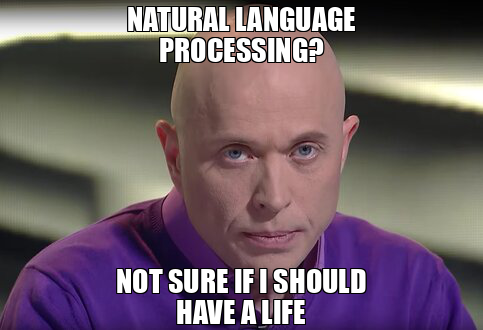

In [ ]:
w_lstm_model.cuda()
get_a_meme(
    model=w_lstm_model, T=1.3,
    beam_size=10,
    top_k=100,
    img_torch=img_torch,
    img_pil=img_pil,
    caption=caption,
    labels=None,
    mode='word',
    device='cuda')

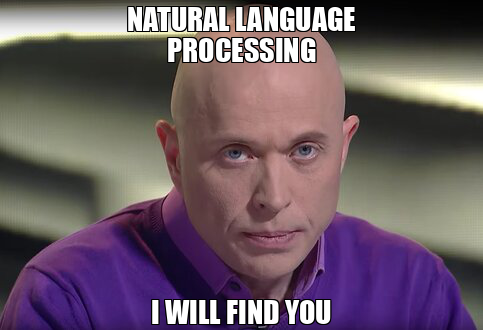

In [ ]:
ch_lstm_model.cuda()
get_a_meme(
    model=ch_lstm_model, T=1.1,
    beam_size=7,
    top_k=50,
    img_torch=img_torch,
    img_pil=img_pil,
    caption=caption,
    labels=None,
    mode='char',
    device='cuda')

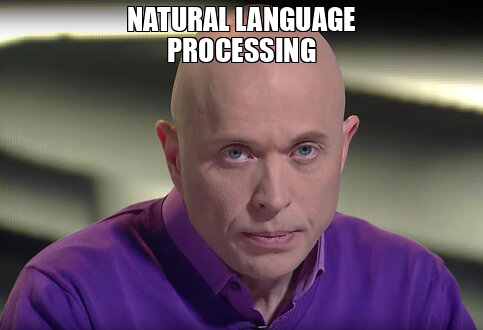

In [ ]:
w_transformer_model.cuda()
get_a_meme(
    model=w_transformer_model, T=1.0,
    beam_size=10,
    top_k=70,
    img_torch=img_torch,
    img_pil=img_pil,
    caption=caption,
    labels=None,
    mode='word',
    device='cuda')